# ME 595r - Autonomous Sytems
# Particle Filter

## Dynamic Model
This filter will estimate the states of a ground robot with velocity inputs and a sensor that measures range and bearing to landmarks. The state is parameterized as
$$ x = \begin{bmatrix}x \\ y \\ \theta \end{bmatrix} $$

The commanded input is

$$ \hat{u} = \begin{bmatrix} \hat{v} \\ \hat{\omega} \end{bmatrix} $$

The true input to the system is equal to the commanded input corrupted by noise

$$ u = \hat{u} + \xi_u $$

Where $ \xi_u $ is a zero-mean multivariate random variable with covariance

$$ \Sigma_{\xi_u} = \begin{bmatrix} \alpha_1 v_t^2 + \alpha_2 \omega_t^2 & 0 \\ 0 & \alpha_3 v_t^2 + \alpha_4 \omega_t^2 \end{bmatrix} $$

The state evolves as

$$ \bar{x}_t = f(x, u) = x_{t-1} + 
\begin{bmatrix} 
-\tfrac{v_t}{\omega_t}\sin(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\sin(\theta_{t-1} + \omega_t \Delta t) \\
\tfrac{v_t}{\omega_t}\cos(\theta_{t-1}) - \tfrac{v_t}{\omega_t}\cos(\theta_{t-1} + \omega_t \Delta t) \\
\omega_t \Delta t
\end{bmatrix} $$


## Measurements and Noise
We will measure the range and bearing to landmarks

## Implementation

In [103]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn
from IPython.display import HTML
from tqdm import tqdm
from IPython.core.debugger import Pdb
import scipy.io as sio
pdb = Pdb()
# pdb.set_trace()
#import plotly.plotly as pl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figWidth = 11
figHeight = 8

In [104]:
mat = sio.loadmat("processed_data.mat")
print(mat.keys())
l_bearing = -np.array(mat['l_bearing'])
l_depth = np.array(mat['l_depth'])
landmarks = np.array(mat['landmarks']).T
vel_odom = np.array(mat['vel_odom'])
odom_t = np.array(mat['odom_t']).flatten()
l_time = np.array(mat['l_time']).flatten()
pos_odom_se2 = np.array(mat['pos_odom_se2'])

['l_bearing', 'l_depth', 'landmarks', 'vel_odom', '__header__', '__globals__', 'odom_t', '__version__', 'l_time', 'pos_odom_se2']


In [123]:
print(vel_odom.shape)
# print(np.array([[6, -7, 6], [4, 8, -4]]))
print(np.nanmin(l_depth))
print(np.nanmax(l_depth))

(2, 2059)
0.00281669464375
6.98595093548


In [208]:
from scipy.stats import multivariate_normal as mvn

class PF(object):
    def __init__(self, X, input_dim, measure_dim, f, g, R, Ts, Q=None, Qu=None):
        self.f = f
        self.g = g
        self.n = X.shape[0]  # state dimension
        self.num_particles = X.shape[1]
        self.m = input_dim  # input dimension
        self.p = measure_dim
#         if Qu is not None:
#             self.Qu = Qu
#         else:
#             self.Qu = lambda u: np.zeros((self.m, self.m))
#         if Q is not None:
#             self.Q = Q
#         else:
#             self.Q = np.zeros((self.n, self.n))
        self.Qu = Qu
        self.Q = Q
        self.R = R
        self.X = X
        self.x = np.mean(self.X, axis=1)[:, np.newaxis]
        self.P = np.cov(self.X, rowvar=True)
        self.Ts = Ts
        
    def lowVarSample(self, w):
        Xbar = np.zeros_like(self.X)
        M = self.num_particles
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 0
        for m in xrange(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            Xbar[:, m] = self.X[:, i]
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self,u, dt):
        self.u = u
        
        # input noise case
        uHat = u[:, np.newaxis] + np.zeros((self.m, self.num_particles))
        if self.Qu is not None:
            uHat = uHat + np.random.multivariate_normal(np.zeros(self.m), self.Qu(u), size=self.num_particles).T
        
        # propagate the particles
#         pdb.set_trace()
        self.X = self.f(self.X, uHat, dt)
        
        if self.Q is not None:
            self.X += np.random.multivariate_normal(np.zeros(self.n), self.Q, size=self.num_particles).T
        

        self.x = np.mean(self.X, axis=1)[:, np.newaxis]
        self.P = np.cov(self.X, rowvar=True)
#         print(self.X.shape)
#         print(self.P.shape)
#         print(self.x)
        
        
    def update(self, z, landmark):

        zHat = g(self.X, landmarks)
        
        w = np.zeros(self.num_particles)
        
        for i in xrange(z.shape[1]):
            if not np.isnan(z[:, i]).any():
                wi = 0.99*mvn.pdf(zHat[:, i, :].T, mean=z[:, i], cov=self.R).T
                # add in a 1% mixture of uniform over range measurements between 1m and 11m
                wi += 0.01*0.1
                w += wi
#             print(w)
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print(w)
        
        unique = self.lowVarSample(w)
        # add some noise to account for sparsity in particles
        if unique/self.num_particles < 0.5:
            Q = self.P/((self.num_particles*unique)**(1/self.n))
            self.X += np.random.multivariate_normal(np.zeros(self.n), Q, size=self.num_particles).T
#         if unique/self.num_particles < 0.1:
#             xHat0 = np.array([[5.], [8.], [0.]])

#             xbound = 5
#             ybound = 10
#             theta_bound = np.pi
#             n = self.X.shape[1]//10
#             X_0 = np.vstack((np.random.uniform(-xbound, xbound, n) + xHat[0, 0],
#                              np.random.uniform(-ybound, ybound, n) + xHat[1, 0],
#                              np.random.uniform(-theta_bound, theta_bound, n) + xHat[2, 0]))
#             self.X[:, :n] = X_0
        
        
        self.x = np.mean(self.X, axis=1)[:, np.newaxis]
        self.P = np.cov(self.X, rowvar=True)
        

In [214]:
# initialize inputs and state truth

Ts = 0.05
Tend = 20

num_particles = 5000

t = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

# alpha = np.array([0.1, 0.01, 0.01, 0.1])
alpha = np.array([0.5, 0.1, 0.1, 0.5])

v_c = 1 + 0.5*np.cos(2*np.pi*0.2*t)
omega_c = -0.2 + 2*np.cos(2*np.pi*0.6*t)

v = v_c + np.random.normal(0, alpha[0]*np.square(v_c) + alpha[1]*np.square(omega_c))
omega = omega_c + np.random.normal(0, alpha[2]*np.square(v_c) + alpha[3]*np.square(omega_c))

u_c = np.vstack((v_c, omega_c))
u = np.vstack((v, omega))
# print(u.shape)
x = np.zeros((3, len(t)))
x[:, 0] = np.array([-5, -3, np.pi/2])

#landmarks = np.array([[6, -7, 6], [4, 8, -4]])

#landmarks = 5*np.random.randn(2, 6)


# define the model
def f(x, u, dt):
    v = u[0, :]
    w = u[1, :]
    w[np.abs(w) < 10*np.finfo(np.float32).eps] = 10*np.finfo(np.float32).eps

    theta = x[2, :]
    dx = np.array([-v/w*np.sin(theta) + v/w*np.sin(theta + w*dt),
                         v/w*np.cos(theta) - v/w*np.cos(theta + w*dt),
                         w*dt])
    x_next = x + dx
    #print(x_next)
    return x_next



def g(x, landmark):
    q = (landmark[0:1, :, np.newaxis] - x[0])**2 + (landmark[1:2, :, np.newaxis] - x[1])**2
    theta = np.arctan2(landmark[1:2, :, np.newaxis] - x[1], landmark[0:1, :, np.newaxis] - x[0]) - x[2]
    theta = ( theta + np.pi) % (2 * np.pi ) - np.pi
    return np.concatenate((np.sqrt(q), theta), axis=0)


def Qu(u):
    v = u[0]
    w = u[1]
    return np.array([[alpha[0]*v**2 + alpha[1]*w**2, 0],
                     [0, alpha[2]*v**2 + alpha[3]*w**2]])

sigma_r = 0.5#0.1
sigma_phi = 0.1#0.05
R = np.array([[sigma_r**2, 0],
              [0, sigma_phi**2]])

# for landmark in landmarks.T:
#     print(landmark)

# generate truth data
# print("You can't handle the truth...")
# for i in tqdm(xrange(1, len(t)), desc="Generating Truth", ncols=110):
#     x[:, i:i+1] = f(x[:, i-1:i], u[:, i:i+1], Ts)

    
xHat = np.zeros_like(pos_odom_se2)
#xHat[:, 0:1] = np.array([[6.86], [14.25], [-2.61]])
xHat[:, 0:1] = np.array([[5.], [8.], [0.]])
sig = np.zeros_like(pos_odom_se2)
# sig[:, 0] = np.sqrt(P.diagonal())
# K = np.zeros((3, 2, len(t)-1))
input_dim = u.shape[0]
measure_dim = 2

# initialize some particles
# bound = 2
# theta_bound = np.pi/10
xbound = 5
ybound = 10
theta_bound = np.pi
X_0 = np.vstack((np.random.uniform(-xbound, xbound, num_particles) + xHat[0, 0],
                 np.random.uniform(-ybound, ybound, num_particles) + xHat[1, 0],
                 np.random.uniform(-theta_bound, theta_bound, num_particles) + xHat[2, 0]))
#__init__(self, X, input_dim, measure_dim, f, g, R, P, Ts, Q=None, Qu=None)
pf = PF(X_0, input_dim, measure_dim, f, g, R, Ts, Qu=Qu)

X = np.zeros((3, num_particles, len(odom_t)))
X[:, :, 0] = X_0
dt = odom_t[1:] - odom_t[:-1]
print("Processing")
landmark_idx = 0
for i in tqdm(xrange(1, len(odom_t)), desc="Estimating", ncols=110):
    uHat = vel_odom[:, i]
    pf.predict(uHat, dt[i-1])
    
    
    while landmark_idx < len(l_time) and odom_t[i] > l_time[landmark_idx]:
        z = np.vstack((l_depth[:, landmark_idx:landmark_idx+1].T, l_bearing[:, landmark_idx:landmark_idx+1].T))
        pf.update(z, landmarks)
        landmark_idx += 1
    
    xHat[:, i:i+1] = pf.x
    sig[:, i] = np.sqrt(pf.P.diagonal())
    X[:, :, i] = pf.X
    

# e = np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2))

# print("Error norm = {}".format(np.linalg.norm(e[10:])*Ts))
    


Estimating:   1%|▋                                                         | 23/2058 [00:00<00:09, 207.74it/s]

Processing


Estimating: 100%|████████████████████████████████████████████████████████| 2058/2058 [00:08<00:00, 242.50it/s]


## Particle Filter output

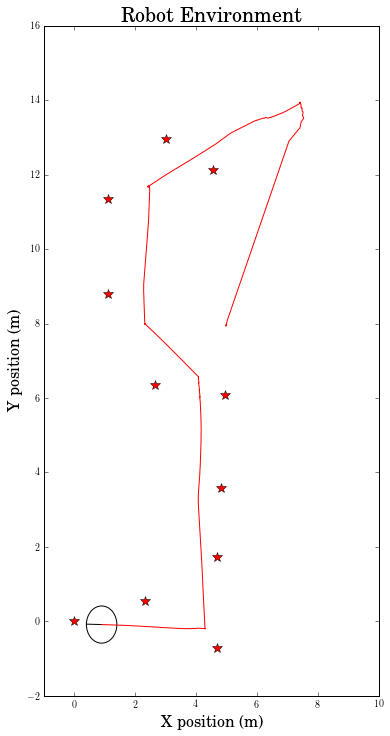

In [215]:
plt.close('all')
env = plt.figure(figsize=(6, 12))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-1, 10))
ax.set_ylim((-2, 16))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

#robot = plt.Circle((x[0, -1], x[1, -1]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, -1], xHat[1, -1]), 0.5, fill=False)
#ax.add_artist(robot)
ax.add_artist(robotHat)
# direction = np.array([[0, np.cos(x[2, -1])], [0, np.sin(x[2, -1])]])/2
# line, = ax.plot(x[0, -1] + direction[0, :], x[1, -1] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, -1])], [0, np.sin(xHat[2, -1])]])/2
lineHat, = ax.plot(xHat[0, -1] + directionHat[0, :], xHat[1, -1] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'r*', markersize=10)
# truth, = ax.plot(x[0, :], x[1, :], 'b:')
estimate, = ax.plot(xHat[0, :], xHat[1, :], 'r')
# particles, = ax.plot(X[0, :, -1], X[1, :, -1], 'go', markersize=2, markeredgewidth=0.0)
plt.show()

In [221]:
plt.close('all')
env = plt.figure(figsize=(4, 6))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-1, 10))
ax.set_ylim((-2, 16))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robotHat = plt.Circle((xHat[0, 0], xHat[1, 0]), 0.5, fill=False)
ax.add_artist(robotHat)
directionHat = np.array([[0, np.cos(xHat[2, 0])], [0, np.sin(xHat[2, 0])]])/2
lineHat, = ax.plot(xHat[0, 0] + directionHat[0, :], xHat[1, 0] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'r*', markersize=10)
estimate, = ax.plot(xHat[0, 0], xHat[1, 0], 'r')
particles, = ax.plot(X[0, :, 0], X[1, :, 0], 'go', markersize=1.5, markeredgewidth=0.0)

# cart = np.array([zHat[0, 0]*np.cos(zHat[1, 0]+xHat[2, 0]), zHat[0, 0]*np.sin(zHat[1, 0]+xHat[2, 0])])
# measurement, = ax.plot([xHat[0, 0], xHat[0, 0] + cart[0]], [xHat[1, 0], xHat[1, 0] + cart[1]], 'y--')

# animation function. This is called sequentially
def animate(i):
    directionHat = np.array([[0, np.cos(xHat[2, i])], [0, np.sin(xHat[2, i])]])/2
    lineHat.set_data(xHat[0, i] + directionHat[0, :], xHat[1, i] + directionHat[1, :])
    robotHat.center = xHat[0, i], xHat[1, i]
    estimate.set_data(xHat[0, :i], xHat[1, :i])
    particles.set_data(X[0, :, i], X[1, :, i])
    # measurement to first landmark
#     cart = np.array([zHat[0, i]*np.cos(zHat[1, i]+xHat[2, i]), zHat[0, i]*np.sin(zHat[1, i]+xHat[2, i])])
#     measurement.set_data([xHat[0, i], xHat[0, i] + cart[0]], [xHat[1, i], xHat[1, i] + cart[1]])
    return (lineHat,)

# call the animator. blit=True means only re-draw the parts that have changed.
speedup = 2
anim = animation.FuncAnimation(env, animate, frames=np.arange(0, len(odom_t), 1), interval=Ts*1000/speedup, blit=True)
# anim = animation.FuncAnimation(env, animate, frames=np.arange(len(odom_t)-400, len(odom_t), 4), interval=Ts*1000/speedup, blit=True)
# anim = animation.FuncAnimation(env, animate, frames=np.arange(0, 50, 1), interval=Ts*1000/speedup, blit=True)

#print(animation.writers.list())
HTML(anim.to_html5_video())

## Odometry Only

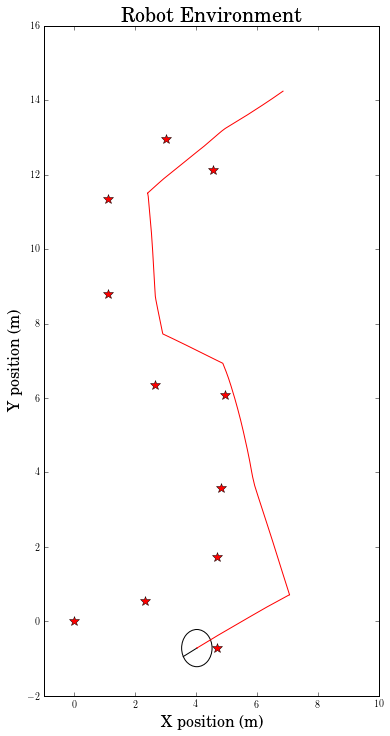

In [63]:
plt.close('all')
env = plt.figure(figsize=(6, 12))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-1, 10))
ax.set_ylim((-2, 16))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

#robot = plt.Circle((x[0, -1], x[1, -1]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((pos_odom_se2[0, -1], pos_odom_se2[1, -1]), 0.5, fill=False)
#ax.add_artist(robot)
ax.add_artist(robotHat)
# direction = np.array([[0, np.cos(x[2, -1])], [0, np.sin(x[2, -1])]])/2
# line, = ax.plot(x[0, -1] + direction[0, :], x[1, -1] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(pos_odom_se2[2, -1])], [0, np.sin(pos_odom_se2[2, -1])]])/2
lineHat, = ax.plot(pos_odom_se2[0, -1] + directionHat[0, :], pos_odom_se2[1, -1] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'r*', markersize=10)
# truth, = ax.plot(x[0, :], x[1, :], 'b:')
estimate, = ax.plot(pos_odom_se2[0, :], pos_odom_se2[1, :], 'r')
# particles, = ax.plot(X[0, :, -1], X[1, :, -1], 'go', markersize=2, markeredgewidth=0.0)
plt.show()

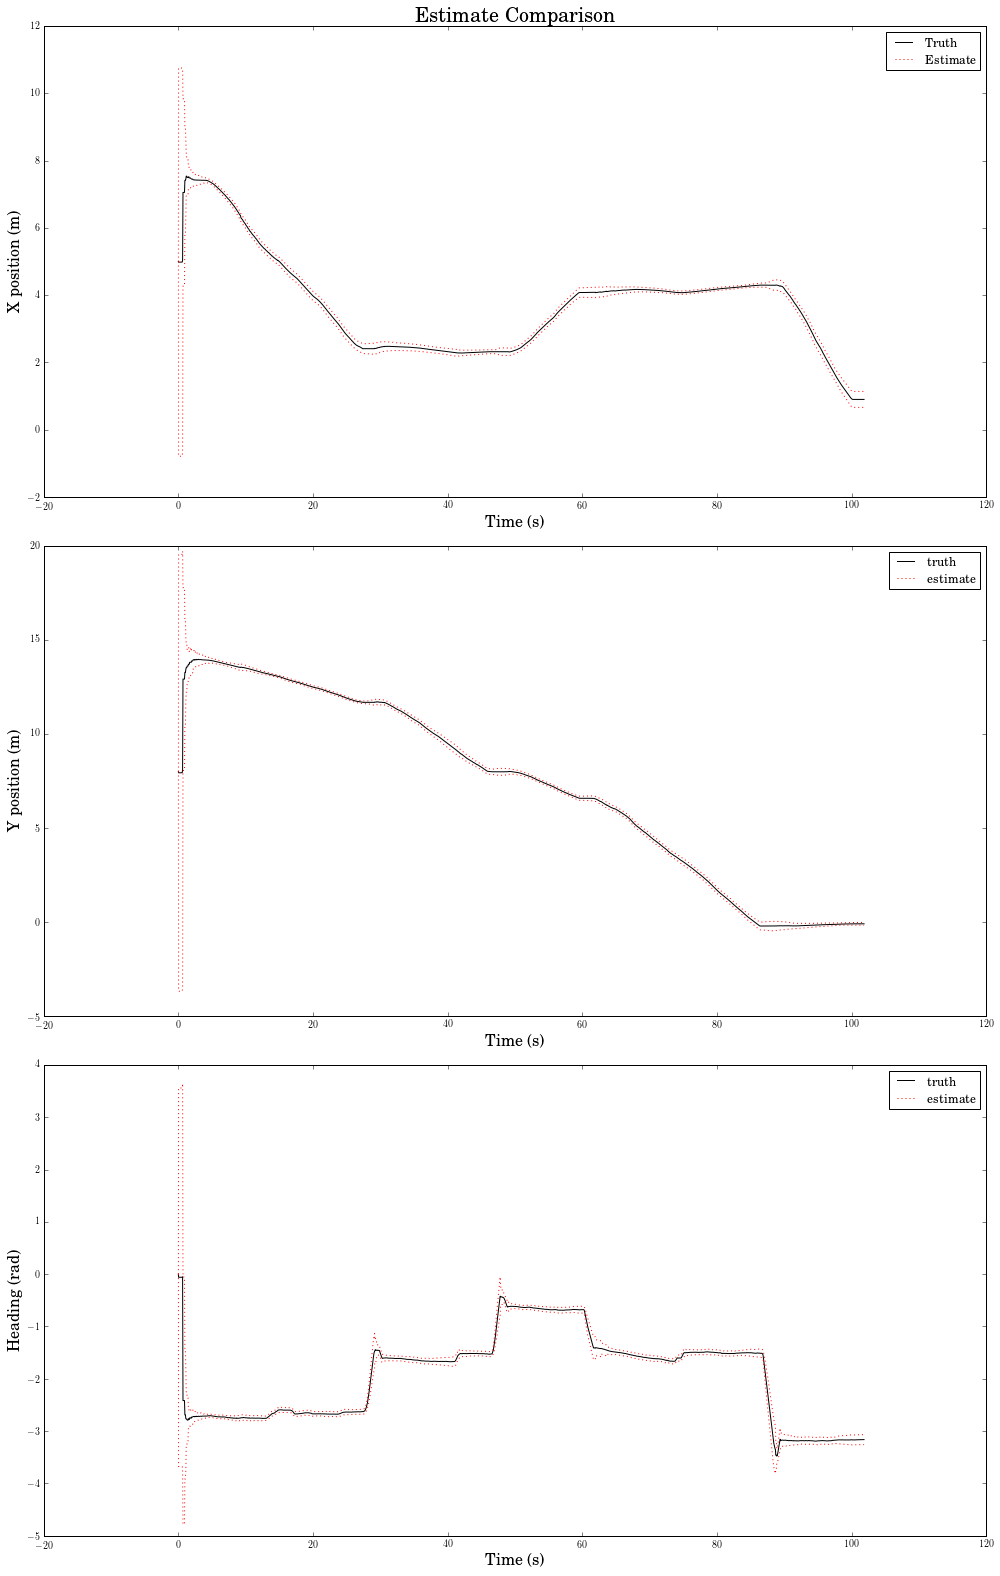

In [219]:
fig = plt.figure(figsize=(14,22))
fig.clear()
ax1 = fig.add_subplot(3, 1, 1)
# ax1.plot(t, x[0, :], 'b:')
ax1.plot(odom_t, xHat[0, :], 'k')
ax1.plot(odom_t, xHat[0, :]+2*sig[0, :], 'r:')
ax1.plot(odom_t, xHat[0, :]-2*sig[0, :], 'r:')
ax1.set_title("Estimate Comparison",fontsize=20)
ax1.legend(["truth", "estimate"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("X position (m)", fontsize=16)
ax1.legend(["Truth", "Estimate"])

ax1 = fig.add_subplot(3, 1, 2)
# ax1.plot(t, x[1, :], 'b:')
ax1.plot(odom_t, xHat[1, :], 'k')
ax1.plot(odom_t, xHat[1, :]+2*sig[1, :], 'r:')
ax1.plot(odom_t, xHat[1, :]-2*sig[1, :], 'r:')
#ax1.set_title("Y Position",fontsize=20)
ax1.legend(["truth", "estimate"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Y position (m)", fontsize=16)

ax1 = fig.add_subplot(3, 1, 3)
# ax1.plot(t, x[2, :], 'b:')
ax1.plot(odom_t, xHat[2, :], 'k')
ax1.plot(odom_t, xHat[2, :]+2*sig[2, :], 'r:')
ax1.plot(odom_t, xHat[2, :]-2*sig[2, :], 'r:')
#ax1.set_title("Theta",fontsize=20)
ax1.legend(["truth", "estimate"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Heading (rad)", fontsize=16)

plt.tight_layout()
plt.show()
